In [81]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## 1. Create dataset and get it ready

In [82]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples of dataset
noOfSamples = 1000

# Create circles
X, y = make_circles(noOfSamples, noise=0.03, random_state=42)

# Checkout created dataset
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")
print(f"Size of X: {X.size}")
print(f"Size of y: {y.size}")
print(f"Dimensions of X: {X.shape}")
print(f"Dimensions of y: {y.shape}")
print(X[:5])
print(y[:5])

Length of X: 1000
Length of y: 1000
Size of X: 2000
Size of y: 1000
Dimensions of X: (1000, 2)
Dimensions of y: (1000,)
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [83]:
# For clear visualization make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"XFeatrue1": X[:,0],
                       "XFeature2": X[:,1],
                       "label": y})

circles.head(10)

,XFeatrue1,XFeature2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


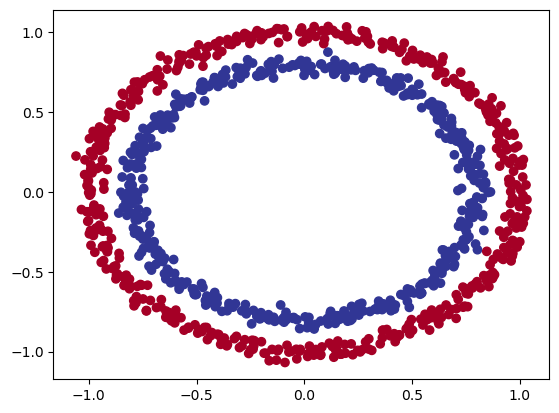

In [84]:
# Visualize the data in diagramatic format

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [85]:
# Convert dataset to tensor
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

In [86]:
# Split data into training and testing
from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42) # 0.2 == 20% for testing

# Details of training and testing data
print(f"Length of XTrain: {len(XTrain)}")
print(f"Length of yTrain: {len(yTrain)} ")
print(f"Length of XTest: {len(XTest)}")
print(f"Length of yTest: {len(yTest)}")

Length of XTrain: 800
Length of yTrain: 800 
Length of XTest: 200
Length of yTest: 200


## 2. Create the Model

In [87]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [88]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.hiddenLayer1 = nn.Linear(in_features=2, out_features=5) # Takes in 2 features as input and outputs 5 features
        self.hiddenLayer2 = nn.Linear(in_features=5, out_features=1) # Takes in 5 features as input and outputs 1 output

    def forward(self, x):
        return self.hiddenLayer2(self.hiddenLayer1(x))  # x -> hiddenLayer1 -> hiddenLayer2 -> output

# Set seed for reproducibility 
torch.manual_seed(42)

# Instantiate the model
circleClassificationModel = CircleModelV0().to(device)

# Check the model's state dictionary
circleClassificationModel.state_dict()

OrderedDict([('hiddenLayer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('hiddenLayer1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('hiddenLayer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('hiddenLayer2.bias', tensor([-0.2060], device='cuda:0'))])

### Create the class using ***'nn.Sequential()'*** 

In [89]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.hiddenLayers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )

    def forward(self, x):
        return self.hiddenLayers(x)

# Set seed for reproducibility  
torch.manual_seed(42)
    
# Instantiate the model
circleClassificationModelLinear = CircleModelV1().to(device)

# Check the model's state dictionary
circleClassificationModelLinear.state_dict()

OrderedDict([('hiddenLayers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('hiddenLayers.0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('hiddenLayers.1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('hiddenLayers.1.bias', tensor([-0.2060], device='cuda:0'))])

In [90]:
# Define the loss function
lossFunction = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = torch.optim.SGD(params=circleClassificationModelLinear.parameters(),
                            lr=0.1)

In [91]:
# Caculate accuracy(%)

def accuracyFunction(yTrue, yPred):
    correct = torch.eq(yTrue, yPred).sum().item()
    accuracy = (correct/len(yPred)) * 100
    return accuracy

### Going from ** raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be ***raw logits***

Can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the **'argmax()'**

In [92]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
XTrain, XTest = XTrain.to(device), XTest.to(device)
yTrain, yTest = yTrain.to(device), yTest.to(device)

# Create training and evaluation loop
for epoch in range(epochs):
    ### Training
    circleClassificationModelLinear.train()

    # Forward propagation
    yLogits = circleClassificationModelLinear(XTrain).squeeze()
    yPreds = torch.round(torch.sigmoid(yLogits))   # Turn logits -> prediction probabilities -> Prediction labels

    # Calculate loss and accuracy
    loss = lossFunction(yLogits, yTrain)
    accuracy = accuracyFunction(yTrue=yTrain, yPred=yPreds)  # Accuracy for our visualization 

    # Zero the gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update the parameters
    optimizer.step()

    ### Testing
    circleClassificationModelLinear.eval()

    with torch.inference_mode():
        # Forward propagation
        yLogitsTest = circleClassificationModelLinear(XTest).squeeze()
        yPredTest = torch.round(torch.sigmoid(yLogitsTest))

        # Calculate loss and accuracy
        testLoss = lossFunction(yLogitsTest, yTest)
        testAccuracy = accuracyFunction(yTrue=yTest, yPred=yPredTest)

    # Print the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss} | Train Accuracy: {accuracy}% | Test Loss: {testLoss} | Test Accuracy: {testAccuracy}%")
    
    
    

Epoch: 0 | Train Loss: 0.6956853866577148 | Train Accuracy: 50.0% | Test Loss: 0.6972115635871887 | Test Accuracy: 50.0%
Epoch: 10 | Train Loss: 0.6940256357192993 | Train Accuracy: 50.0% | Test Loss: 0.696153998374939 | Test Accuracy: 50.0%
Epoch: 20 | Train Loss: 0.6934275031089783 | Train Accuracy: 46.0% | Test Loss: 0.6958542466163635 | Test Accuracy: 48.5%
Epoch: 30 | Train Loss: 0.6932066082954407 | Train Accuracy: 49.0% | Test Loss: 0.6957688927650452 | Test Accuracy: 47.5%
Epoch: 40 | Train Loss: 0.6931198239326477 | Train Accuracy: 49.5% | Test Loss: 0.6957287192344666 | Test Accuracy: 46.5%
Epoch: 50 | Train Loss: 0.693081259727478 | Train Accuracy: 50.375% | Test Loss: 0.695688784122467 | Test Accuracy: 46.5%
Epoch: 60 | Train Loss: 0.6930606961250305 | Train Accuracy: 50.5% | Test Loss: 0.6956409215927124 | Test Accuracy: 46.5%
Epoch: 70 | Train Loss: 0.6930473446846008 | Train Accuracy: 50.5% | Test Loss: 0.6955872774124146 | Test Accuracy: 46.5%
Epoch: 80 | Train Loss: 0.

### To inspect the model make them visual!

To do so, we're going to import a function called ***plot_decision_boundary()*** - **https://github.com/mrdbourke/pytorch-deep-learning**

In [93]:
### Get github repositories files

import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already download)
if Path("Helper_Functions/helper_function.py").is_file():
    print("helper_function.py already exists, skipping downlaoad")
else:
    print("Downloading helper_function.py")
    requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("Helper_Functions/helper_function.py", "wb") as file:
        file.write(requests.content)

from Helper_Functions.helper_function import plot_predictions, plot_decision_boundary

helper_function.py already exists, skipping downlaoad


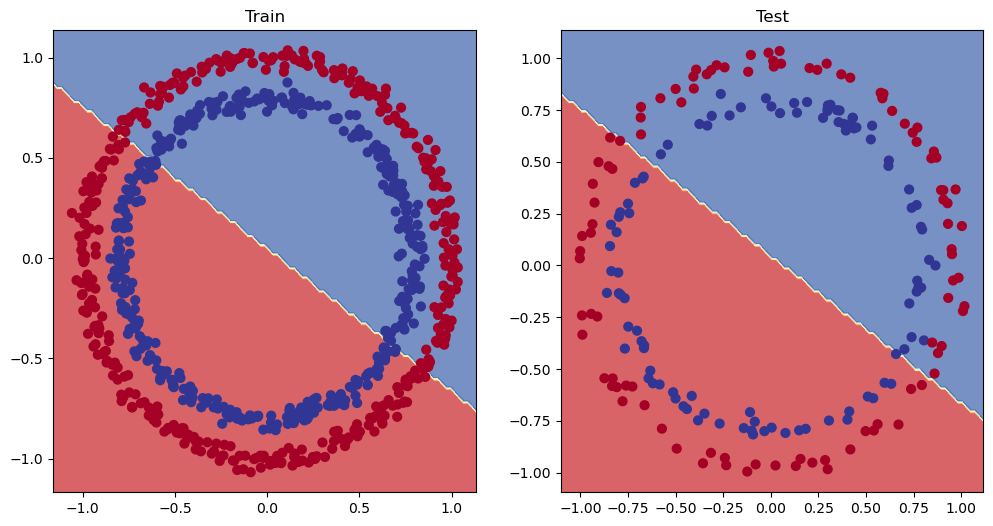

In [94]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=circleClassificationModelLinear,
                       X=XTrain,
                       y=yTrain)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=circleClassificationModelLinear,
                       X=XTest,
                       y=yTest)

# 1. Improving the model (from model perspective)
* Adding layers
* Increase the number of hidden units
* Change/Add activation functions
* Change the optimization function
* Change the learning rate
* Fitting for longer

**Let's try to improve our model by:**
* Adding more hidden units: 5->10
* Increase the number of layers: 2->3
* Increase the number of epochs: 100->1000

In [95]:
class circleClassificationModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.hiddenLayers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Linear(in_features=10, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        return self.hiddenLayers(x)
    
# Create an instance of newly created class 
circleClassificationModelLinearV1 = circleClassificationModelV1().to(device)
circleClassificationModelLinearV1

circleClassificationModelV1(
  (hiddenLayers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

***We can use same loss function if we don't want to change it.***

***Since we have change the model we have to re-initialize the optimizer to give correct parameters.***

In [96]:
# Re-initialize the optimizer

optimizer = torch.optim.SGD(params=circleClassificationModelLinearV1.parameters(),
                            lr=0.1)

# Set seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Training and evaluation loop
for epoch in range(epochs):
    ### Training
    circleClassificationModelLinearV1.train()

    # Forward propagation
    yLogits = circleClassificationModelLinearV1(XTrain).squeeze()
    yPreds = torch.round(torch.sigmoid(yLogits))

    # Calculate loss and accuaracy
    loss = lossFunction(yLogits, yTrain)
    accuracy = accuracyFunction(yTrue=yTrain, yPred=yPreds)

    # Zero the gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Update the parameters
    optimizer.step()

    ### Testing
    circleClassificationModelLinearV1.eval()

    with torch.inference_mode():
        # Forward propagation
        yLogitsTest = circleClassificationModelLinearV1(XTest).squeeze()
        yPredTest = torch.round(torch.sigmoid(yLogitsTest))

        # Calculate the loss
        testLoss = lossFunction(yLogitsTest, yTest)
        testAccuracy = accuracyFunction(yTrue=yTest, yPred=yPredTest)

    # Print the results
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss} | Train Accuracy: {accuracy}% | Test Loss: {testLoss} | Test Accuracy: {testAccuracy}%")

Epoch: 0 | Train Loss: 0.6939550638198853 | Train Accuracy: 50.875% | Test Loss: 0.6926146745681763 | Test Accuracy: 51.0%
Epoch: 10 | Train Loss: 0.6936882138252258 | Train Accuracy: 50.24999999999999% | Test Loss: 0.6927036643028259 | Test Accuracy: 50.0%
Epoch: 20 | Train Loss: 0.6935123801231384 | Train Accuracy: 50.125% | Test Loss: 0.6928302049636841 | Test Accuracy: 49.5%
Epoch: 30 | Train Loss: 0.6933860778808594 | Train Accuracy: 50.5% | Test Loss: 0.6929663419723511 | Test Accuracy: 48.0%
Epoch: 40 | Train Loss: 0.6932917833328247 | Train Accuracy: 50.375% | Test Loss: 0.693103015422821 | Test Accuracy: 49.0%
Epoch: 50 | Train Loss: 0.6932203769683838 | Train Accuracy: 49.875% | Test Loss: 0.6932356953620911 | Test Accuracy: 50.0%
Epoch: 60 | Train Loss: 0.6931657791137695 | Train Accuracy: 49.375% | Test Loss: 0.6933622360229492 | Test Accuracy: 51.5%
Epoch: 70 | Train Loss: 0.6931239366531372 | Train Accuracy: 49.375% | Test Loss: 0.6934814453125 | Test Accuracy: 50.5%
Epoc

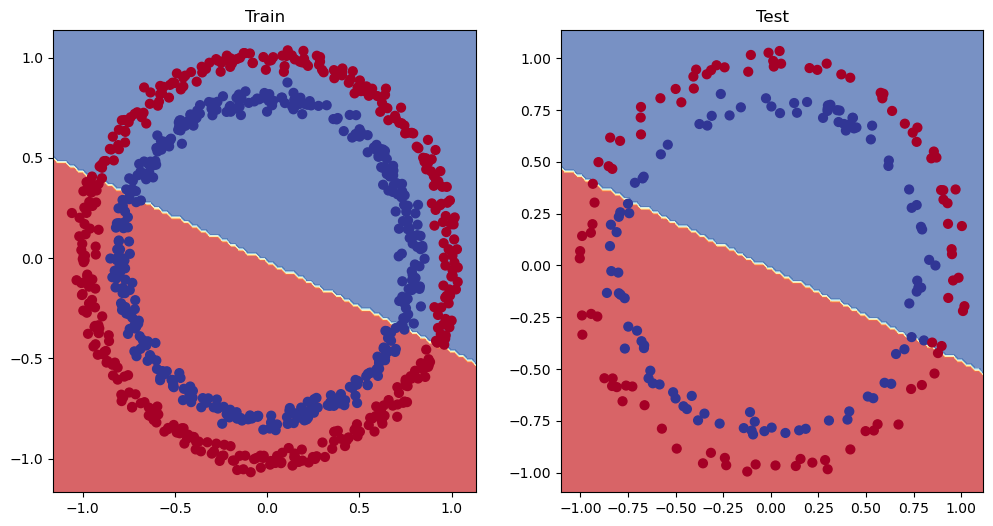

In [97]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=circleClassificationModelLinearV1,
                       X=XTrain,
                       y=yTrain)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=circleClassificationModelLinearV1,
                       X=XTest,
                       y=yTest)